# 引言

### 研究目的
传统的因子指标挖掘主要集中于财务报表、个股中低频率的价量等相关的数据维度，而这部分数据维度的增量价值的挖掘已逐渐饱和，需从其他新的数据维度中挖掘新的因子指标，本篇研究内容参考海通证券研报《高频量价因子在股票与期货中的表现》，本篇报告从个股日内高频数据出发,将目光聚焦于日内价量信息和交易特征，使用分钟数据构建一系列高频因子，实证各因子在股票市场中的表现（本研究主要探讨股票部分，原研报期货部分未做研究）。



### 研究框架
高频因子可以分为收益率分布、成交量分布、量价复合、资金流和日内动量等几个主要的类别，各类因子还可以做进一步的细化，例如收益率分布因子包括已实现偏度、已实现峰度和上下行波动率等。按照这个思路，展开研究：

1）因子数据获取：
 - 从设置股票池，获取指定时间范围的分钟数据，按照研报思路，获取每分钟的数据，进行因子值计算函数构造，按日期将因子值存入字典

2）因子数据处理：
  - 将计算出来的因子值按日期遍历获取，根据需要进行数据处理
  - 在T期因子值中加入T+1期收益值，方便因子分析统计

3）因子统计分析：
  - 针对每期截面进行因子IC统计
  - 汇总为时间序列上的IC数据，进行展示

4）分组回测分析：
  - 根据所选的因子，在每个调仓日进行股票排序，分层进行收益净值观察
  - 根据所选因子，在每个调仓日进行股票排序，进行多头组合收益分析
  
###  参数设置

1）时间范围：
- 2014.6 ～ 2019.6

2）研究指数：
- 上证50、沪深300、中证500

3）股票池：
- 上证50、沪深300、中证500指数成分股以及全部A股
- 剔除 ST、停牌、涨跌停、上市不满 6 个月
- 月初调仓


4）费用设置：
- 暂无交易成本设置


### 研究内容及结论

1）收益率分布因子。 
- 高频偏度因子与高频峰度因子具有一定的选股效果，统计期高频偏度因子 IC均值达到0.034 与0.0198，负值占比为 69.5% 与 71.2%，多空组合年化收益差分别为 14.45% 和 15%，最优分组年化收益为 18.02% 和 20.9%，且因子在股票中呈现出反转效应，即高频偏度与峰度小的股票未来收益表现更好，下行波动占比因子未有良好表现（最优分组默认头尾分组）。

2）成交量分布因子。 
- 日内不同时段的成交量分布能够反映投资者的行为特征。上午10 点-11 点成交量占比因子和股票下月收益显著正相关，而收盘前半小时成交量占比因子和股票下月收益显著负相关，IC均值达到0.040 与0.0565，负值占比为 35.6% 与 72.9%，二者分层效果明显，多空组合年化收益差均可以到达 17%左右，最优分组年化收益率分别为 22.33% 和 25.21%（默认头尾分组）。

3）量价复合因子。 
- 高频量价相关性因子具有显著选股效果，日内走势呈现出“量价背离” 特征的股票未来收益表现好于“量价同向”的股票，IC均值达到 -0.047 ，负值占比为 62.7%。分层效果较为明显（最优分组在中间），多空组合年化收益差可以到达 21%，最优分组年化收益率为 19.12%。


4） 资金流因子。 
- 资金流向来自交易时产生的委托信息，反映的是微观层面的供求关系，IC均值达到 -0.0519，负值占比为 55.9%，分层效果很显著，多空组合年化收益差可以到达 30%，最优分组年化收益率为 26.57%。

5）趋势强度因子。 
- 股票趋势强度因子选股效果一般，IC统计均值为 -0.009，负值占比为 0.491 %，分层效果比较显著，多空组合年化收益差为 13%，最优分组年化收益率为 18.77%。

6） 改进反转因子。 
- 除了直接使用分钟级别数据构建因子之外，我们还可以使用日内信息对传统因子做增强。 剔除了隔夜和开盘后小时涨幅的一个月反转因子的多投组合日均收益达到0.106%，分层效果明显，多空组合年化收益差可达27.6%，最优分组年化收益到达24.12%

In [2]:
#导入需要的库、定义需要用到的工具函数
#工具函数
import time
from datetime import datetime, timedelta
from jqdata import *
import numpy as np
import pandas as pd
import math
from statsmodels import regression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime
from scipy import stats
from jqfactor import *
import warnings  
warnings.filterwarnings('ignore') 
plt.style.use('ggplot')

#输入起止日期，返回所有自然日日期
def get_date_list(begin_date, end_date):
    dates = []
    dt = datetime.strptime(begin_date,"%Y-%m-%d")
    date = begin_date[:]
    while date <= end_date:
        dates.append(date)
        dt += timedelta(days=1)
        date = dt.strftime("%Y-%m-%d")
    return dates

#获取日期列表
def get_tradeday_list(start,end,frequency=None,count=None):
    if count != None:
        df = get_price('000001.XSHG',end_date=end,count=count)
    else:
        df = get_price('000001.XSHG',start_date=start,end_date=end)
    if frequency == None or frequency =='day':
        return df.index
    else:
        df['year-month'] = [str(i)[0:7] for i in df.index]
        if frequency == 'month':
            return df.drop_duplicates('year-month').index
        elif frequency == 'quarter':
            df['month'] = [str(i)[5:7] for i in df.index]
            df = df[(df['month']=='01') | (df['month']=='04') | (df['month']=='07') | (df['month']=='10') ]
            return df.drop_duplicates('year-month').index
        elif frequency =='halfyear':
            df['month'] = [str(i)[5:7] for i in df.index]
            df = df[(df['month']=='01') | (df['month']=='06')]
            return df.drop_duplicates('year-month').index 

#输入开始日期和结束日期，返回每周第一个交易日
def get_weekday(s_date,d_date):
    df = get_price('000001.XSHG',start_date=s_date,end_date=d_date)
    dt_list = []
    for d1,d2 in zip(df.index[:-1],df.index[1:]):
        d_1 = datetime.datetime(int(str(d1)[:4]),int(str(d1)[5:7]),int(str(d1)[8:10]))
        d_2 = datetime.datetime(int(str(d2)[:4]),int(str(d2)[5:7]),int(str(d2)[8:10]))
        weekday1 = d_1.strftime("%w")
        weekday2 = d_2.strftime("%w")
        interday = (d_2 - d_1).days
        if (int(weekday1) >= int(weekday2)) or interday>7:
            dt_list.append(str(d2)[:10])
    return dt_list        

def ret_se(start_date='2018-6-1',end_date='2018-7-1',stock_pool=None,weight=0):
    pool = stock_pool
    if len(pool) != 0:
        #得到股票的历史价格数据
        df = get_price(list(pool),start_date=start_date,end_date=end_date,fields=['close']).close
        df = df.dropna(axis=1)
        #获取列表中的股票流通市值对数值
        df_mkt = get_fundamentals(query(valuation.code,valuation.circulating_market_cap).filter(valuation.code.in_(df.columns)))
        df_mkt.index = df_mkt['code'].values
        fact_se =pd.Series(df_mkt['circulating_market_cap'].values,index = df_mkt['code'].values)
        fact_se = np.log(fact_se)
    else:
        df = get_price('000001.XSHG',start_date=start_date,end_date=end_date,fields=['close'])
        df['v'] = [1]*len(df)
        del df['close']
    #相当于昨天的百分比变化
    pct = df.pct_change()+1
    pct.iloc[0,:] = 1
    if weight == 0:
        #等权重平均收益结果
        se = pct.cumsum(axis=1).iloc[:,-1]/pct.shape[1]
        return se
    else:
        #按权重的方式计算
        se = (pct*fact_se).cumsum(axis=1).iloc[:,-1]/sum(fact_se)
        return se
    
#获取所有分组pct
def get_all_pct(pool_dict,trade_list,groups=5):
    num = 1
    for s,e in zip(trade_list[:-1],trade_list[1:]):
        stock_list = pool_dict[s]
        stock_num = len(stock_list)//groups
        if num == 0:
            pct_se_list = []
            for i in range(groups):
                pct_se_list.append(ret_se(start_date=s,end_date=e,stock_pool=stock_list[i*stock_num:(i+1)*stock_num]))
            pct_df1 = pd.concat(pct_se_list,axis=1)
            pct_df1.columns = range(groups)
            pct_df = pd.concat([pct_df,pct_df1],axis=0)
        else:
            pct_se_list = []
            for i in range(groups):
                pct_se_list.append(ret_se(start_date=s,end_date=e,stock_pool=stock_list[i*stock_num:(i+1)*stock_num]))
            pct_df = pd.concat(pct_se_list,axis=1)    
            pct_df.columns = range(groups)
            num = 0
    return pct_df

def tradedays_before(date,count):#获取指定交易日往前推count天交易日
    date = get_price('000001.XSHG',end_date=date,count=count+1).index[0]
    return date

def ShiftTradingDay(date,shift):
    # 获取所有的交易日，返回一个包含所有交易日的 list,元素值为 datetime.date 类型.
    tradingday = get_all_trade_days()
    # 得到date之后shift天那一天在列表中的行标号 返回一个数
    date = datetime.date(int(str(date)[:4]),int(str(date)[5:7]),int(str(date)[8:10]))
    shiftday_index = list(tradingday).index(date)+shift
    # 根据行号返回该日日期 为datetime.date类型
    return tradingday[shiftday_index] 

#进行新股、St股过滤，返回筛选后的股票
def filter_stock(stockList,date,days=21*3,skip_paused=1,limit=0):#日频策略加入开盘涨停过滤
    
    #去除上市距beginDate不足3个月的股票
    def delect_stop(stocks,beginDate,n=days):
        stockList=[]
        beginDate = datetime.datetime.strptime(beginDate, "%Y-%m-%d")
        for stock in stocks:
            start_date=get_security_info(stock).start_date
            if start_date<(beginDate-datetime.timedelta(days=n)).date():
                stockList.append(stock)
        return stockList
    
    #剔除ST股
    st_data=get_extras('is_st',stockList, count = 1,end_date=date)
    stockList = [stock for stock in stockList if not st_data[stock][0]]

    #剔除当天停牌股
    if skip_paused == 1:
        paused_df = get_price(stockList,end_date=date,count=1,fields=['paused'])['paused'].T
        paused_df.columns = ['paused']
        paused_df = paused_df[paused_df['paused']==0]
        stockList = paused_df.index
    
    #新股及退市股票
    stockList=delect_stop(stockList,date)
    
    #剔除开盘涨停股票
    if limit == 1:
        #如果需要收盘涨跌停可以改字段即可
        df = get_price(stockList,end_date=date,fields=['open','high_limit','low_limit'],count=1).iloc[:,0,:]
        df['h_limit']=(df['open']==df['high_limit'])
        df['l_limit']=(df['open']==df['low_limit'])
        stockList = [df.index[i] for i in range(len(df)) if not (df.h_limit[i] or df.l_limit[i])] #过滤涨跌停股票
    return stockList

###  因子数据获取

In [3]:
# 风险及免责提示：该策略由聚宽用户在聚宽社区分享，仅供学习交流使用。
# 原文一般包含策略说明，如有疑问请到原文和作者交流讨论。
# 原文网址：https://www.joinquant.com/view/community/detail/2bf8fa3b9910c7213222439f9af0f847?type=1
# 标题：海通证券：高频量价因子在股票与期货中的表现

#设置股票池（指数成分股）
index = '000905.XSHG' #设置股票池，和对比基准，这里是中证500

#设置统计起止日期
date_start = '2014-06-01'
date_end   = '2019-06-24'

#获取统计期内交易日列表、用于计算因子数据
date_list = get_tradeday_list(start=date_start,end=date_end,count=None)#获取回测日期间的所有交易日
date_list

DatetimeIndex(['2014-06-03', '2014-06-04', '2014-06-05', '2014-06-06',
               '2014-06-09', '2014-06-10', '2014-06-11', '2014-06-12',
               '2014-06-13', '2014-06-16',
               ...
               '2019-06-11', '2019-06-12', '2019-06-13', '2019-06-14',
               '2019-06-17', '2019-06-18', '2019-06-19', '2019-06-20',
               '2019-06-21', '2019-06-24'],
              dtype='datetime64[ns]', length=1235, freq=None)

根据现有的研究成果，我们可以把高频因子分为收益率分布、成交量分布、量价复合、资金流和日内动量等几个主要的类别， 

各类因子还可以做进一步的细化， 例如收益率分布因子包括已实现偏度、已实现峰度和上下行波动率等等

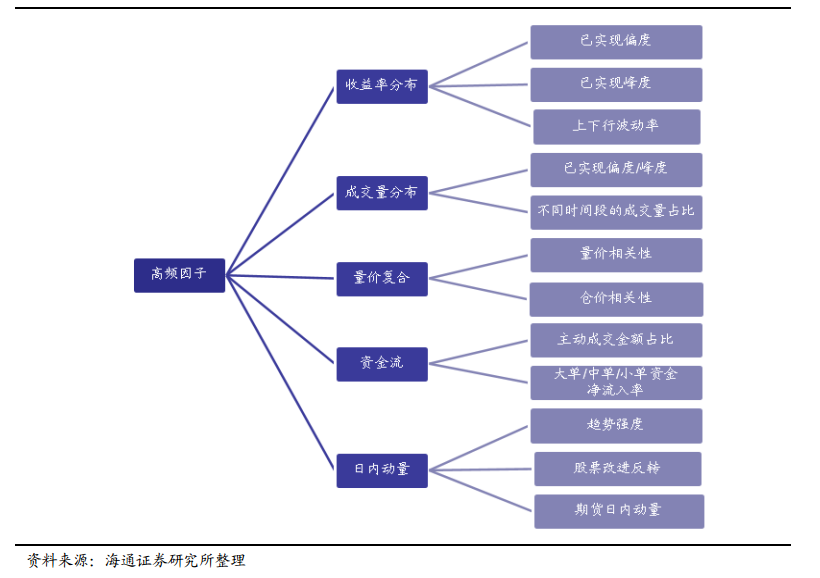

In [3]:
#计算并保存因子值数据
#因子3 偏度与峰度因子与下行波动率
def factor3(pool,date,days=1,freq = 1):#freq用来计算统计频率
    #偏度与峰度因子
    def ffactor3(pool,date,freq = 1):#freq用来计算统计频率
        factor = pd.DataFrame(index = ['RVar_t','RSkew_t','RKurt_t','RVar_t_short'])
        for stock in pool:
            df = pd.DataFrame()
            price = get_price(stock,end_date=str(date)[:10]+' 15:00:00',count=240,frequency='1m',fields=['open','close'])
            price_list = list(price['close'].values)
            price_list.insert(0,price.iloc[0,0])
            df['close'] = price_list
            df.index = range(0,len(df))
            mark_l = [i for i in df.index if i%freq==0]
            df = df.loc[mark_l,:]
            df['ln_c'] = log(df['close'])
            df['r'] = df['ln_c']-df['ln_c'].shift(1)
            df = df.dropna()
            RDVar_t = sum([r**2 for r in df['r'].values])
            RDvar_t_s= sum([r**2 for r in df['r'].values if r <0])
            RDSkew_t= np.sqrt(len(df))*sum([r**3 for r in df['r'].values])/RDVar_t**(3/2)
            RDKurt_t= len(df)*sum([r**4 for r in df['r'].values])/RDVar_t**2
            factor[stock] = [RDVar_t,RDSkew_t,RDKurt_t,RDvar_t_s]
        return factor.T
    
    t = get_price('000001.XSHG',end_date=date,count=days).index
    mark = 1
    for d in t:
        if mark == 0:   
            factor_temp = ffactor3(pool,d,freq = freq)
            factor = factor+factor_temp
        else:
            factor = ffactor3(pool,d,freq = freq)
            mark = 0
    return factor/len(t)

#4 成交量分布因子
def factor4(stocks_list,date):#
    min_df = get_price(stocks_list,end_date=str(date)[:10]+' 15:00:00',frequency='30m',count=8,fields=['volume'])['volume']
    df = min_df.T
    df.columns=[1,2,3,4,5,6,7,8]
    df['sum'] = df.sum(axis=1)
    far = df.div(df['sum'].values,axis=0)
    return far.iloc[:,:-1]

#5 量价复合因子
def factor5(pool,date,days=1,freq = 1):#freq用来计算统计频率
    #高频量价相关性
    def ffactor5(pool,date,freq = 1):#freq用来计算统计频率
        factor = pd.DataFrame(index = ['corr'])
        for stock in pool:
            df = pd.DataFrame()
            price = get_price(stock,end_date=str(date)[:10]+' 15:00:00',count=240,frequency='1m',fields=['close','volume'])
            corr = price['close'].corr(price['volume'])
            factor[stock] = [corr]
        return factor.T
    
    t = get_price('000001.XSHG',end_date=date,count=days).index
    mark = 1
    for d in t:
        if mark == 0:   
            factor_temp = ffactor5(pool,d,freq = freq)
            factor = factor+factor_temp
        else:
            factor = ffactor5(pool,d,freq = freq)
            mark = 0
    return factor/len(t)

#6 资金流因子
def factor6(pool,date,days=1,freq = 1,op=1):#freq用来计算统计频率
    #资金流因子
    def ffactor6(pool,date,freq = 1,op=op):#freq用来计算统计频率
        factor = pd.DataFrame(index = ['flowinratio'])
        for stock in pool:
            df = pd.DataFrame()
            min_df = get_price(stock,end_date=str(date)[:10]+' 15:00:00',frequency='1m',count=240,fields=['open','close','volume','money'])
            min_df['b_s'] = (min_df['close']-min_df['close'].shift(1))/abs(min_df['close']-min_df['close'].shift(1))
            if op == 1:
                min_df.iloc[0,4] =  1 if min_df.iloc[0,1] > min_df.iloc[0,0] else -1 #是否统计第一分钟数据
            flowinratio = sum(min_df[min_df['b_s']==1]['money'])/sum(sum(min_df['money']))
            factor[stock] = [flowinratio]
        return factor.T
    
    t = get_price('000001.XSHG',end_date=date,count=days).index
    mark = 1
    for d in t:
        if mark == 0:   
            factor_temp = ffactor6(pool,d,freq = freq)
            factor = factor+factor_temp
        else:
            factor = ffactor6(pool,d,freq = freq)
            mark = 0
    return factor/len(t)

#因子7 动量类因子
def factor7(stocks_list,date,n1=1,n2=30):
    min_df = get_price(stocks_list,end_date=date+' 15:00:00',frequency='1m',count=241-n1,fields=['close'])['close']
    er_s = min_df.values[-1]-min_df.values[0]
    er_ay = np.array([abs(j-i) for i,j in zip(min_df.values[:-1],min_df.values[1:])])
    er_x = er_ay.sum(axis=0)
    far1 = pd.DataFrame(er_s/er_x,index=stocks_list,columns=['er'])
    
    min_df = get_price(stocks_list,end_date=date+' 15:00:00',frequency='1m',count=241-n2,fields=['close'])['close']
    r = min_df.iloc[-1,:]/min_df.iloc[0,:]-1
    far2 = pd.DataFrame(r,index=stocks_list,columns=['r'])

    return pd.concat([far1,far2],axis=1)

#循环日期列表，进行因子值记录，按字典的方式存储
#进行因子值计算
factor_dict = {}
#循环时间列表获取原始因子数据组成dict
for end_date in date_list[:]:
    end_date=str(end_date)[:10]
    print('正在计算 {} 因子数据......'.format(end_date))
    stocks_list = get_index_stocks(index,date=end_date)#获取指定日期成分股列表
    stocks_list = filter_stock(stocks_list,end_date,days=183,limit=1)#进行股票筛选
    pool = stocks_list
    date = end_date
    factor_dict[end_date] = pd.concat([factor3(pool,date),factor4(pool,date),factor5(pool,date),factor6(pool,date),factor7(pool,date)],axis=1)#计算因子值进行存储

#进行因子值计算
factor1_dict = {}
n = 20
#循环时间列表获取原始因子数据组成dict
for end_date in date_list[20:]:
    date = str(end_date)[:10]
    t = get_price('000001.XSHG',end_date=date,count=n).index
    mark = 1
    for d in t:
        date_ = str(d)[:10]
        if mark == 0:   
            factor_temp = factor_dict[date_]
            factor = factor+factor_temp
        else:
            factor = factor_dict[date_]
            mark = 0
    factor1_dict[date] = factor/len(t)
factor1_dict[date].head(3)

### 因子数据处理

- 进行因子值数据处理、如有必要可进行去极值、标准化、中性化
- 加入收益数据：将T期因子值中加入T~T+1的收益数据进行记录

In [5]:
#参数设置
#设置是否中性化
neu = 0 #1为进行中性化；0为不进行中性化
how_=['sw_l1', 'market_cap'] #中性化

#获取调仓日历、交易列表
s_date = '2014-7-1'
d_date = '2019-6-24'

#获取统计期内交易日列表、用于计算因子数据
trade_list = get_tradeday_list(start=s_date,end=d_date,frequency='month',count=None)#获取每月第一个交易日
trade_list

DatetimeIndex(['2014-07-01', '2014-08-01', '2014-09-01', '2014-10-08',
               '2014-11-03', '2014-12-01', '2015-01-05', '2015-02-02',
               '2015-03-02', '2015-04-01', '2015-05-04', '2015-06-01',
               '2015-07-01', '2015-08-03', '2015-09-01', '2015-10-08',
               '2015-11-02', '2015-12-01', '2016-01-04', '2016-02-01',
               '2016-03-01', '2016-04-01', '2016-05-03', '2016-06-01',
               '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-10',
               '2016-11-01', '2016-12-01', '2017-01-03', '2017-02-03',
               '2017-03-01', '2017-04-05', '2017-05-02', '2017-06-01',
               '2017-07-03', '2017-08-01', '2017-09-01', '2017-10-09',
               '2017-11-01', '2017-12-01', '2018-01-02', '2018-02-01',
               '2018-03-01', '2018-04-02', '2018-05-02', '2018-06-01',
               '2018-07-02', '2018-08-01', '2018-09-03', '2018-10-08',
               '2018-11-01', '2018-12-03', '2019-01-02', '2019-02-01',
      

In [6]:
#数据清洗、包括去极值、标准化、中性化等,并加入y值
import time  
t1 = time.time()
factor_y_dict = {}
for date_1,date_2 in zip(trade_list[:-1],trade_list[1:]):
    d1 = ShiftTradingDay(date_1,1) #往后推一天
    d2 = ShiftTradingDay(date_2,1)
    print('开始整理 {} 数据...'.format(str(date_1)[:10]))
    factor_df = factor1_dict[str(date_1)[:10]] #根据字典存储的日期格式不同进行不同设置
    pool = list(factor_df.index)
    
    #计算指数涨跌幅
    df_1 = get_price(index,end_date=d1,fields=['open'],count = 1)['open']
    df_2 = get_price(index,end_date=d2,fields=['open'],count = 1)['open']
    index_pct = df_2.values[0]/df_1.values[0] - 1#具体数值
    
    #计算各股票涨跌幅
    df_1 = get_price(pool,end_date=d1,fields=['open'],count = 1)['open']
    df_2 = get_price(pool,end_date=d2,fields=['open'],count = 1)['open']
    df_3 = pd.concat([df_1,df_2],axis=0).T #进行合并
    stock_pct = df_3.iloc[:,1]/df_3.iloc[:,0] - 1 #计算pct，series
    
    #对数据进行处理、标准化、去极值、中性化
    #factor_df = winsorize_med(factor_df, scale=3, inclusive=True, inf2nan=True, axis=0) #中位数去极值处理
    #factor_df = standardlize(factor_df, inf2nan=True, axis=0) #对每列做标准化处理
    if neu == 1:
        factor_df = neutralize(factor_df, how=how_, date=date_1, axis=0,fillna='sw_l1')#中性化

    #factor_df['pct_alpha'] =  stock_pct-index_pct
    factor_df['pct_'] =  stock_pct
    factor_y_dict[str(date_1)[:10]] = factor_df
    
t2 = time.time()
print('计算数据耗时：{0}'.format(t2-t1))
print(factor_y_dict[str(date_1)[:10]].shape)

开始整理 2014-07-01 数据...
开始整理 2014-08-01 数据...
开始整理 2014-09-01 数据...
开始整理 2014-10-08 数据...
开始整理 2014-11-03 数据...
开始整理 2014-12-01 数据...
开始整理 2015-01-05 数据...
开始整理 2015-02-02 数据...
开始整理 2015-03-02 数据...
开始整理 2015-04-01 数据...
开始整理 2015-05-04 数据...
开始整理 2015-06-01 数据...
开始整理 2015-07-01 数据...
开始整理 2015-08-03 数据...
开始整理 2015-09-01 数据...
开始整理 2015-10-08 数据...
开始整理 2015-11-02 数据...
开始整理 2015-12-01 数据...
开始整理 2016-01-04 数据...
开始整理 2016-02-01 数据...
开始整理 2016-03-01 数据...
开始整理 2016-04-01 数据...
开始整理 2016-05-03 数据...
开始整理 2016-06-01 数据...
开始整理 2016-07-01 数据...
开始整理 2016-08-01 数据...
开始整理 2016-09-01 数据...
开始整理 2016-10-10 数据...
开始整理 2016-11-01 数据...
开始整理 2016-12-01 数据...
开始整理 2017-01-03 数据...
开始整理 2017-02-03 数据...
开始整理 2017-03-01 数据...
开始整理 2017-04-05 数据...
开始整理 2017-05-02 数据...
开始整理 2017-06-01 数据...
开始整理 2017-07-03 数据...
开始整理 2017-08-01 数据...
开始整理 2017-09-01 数据...
开始整理 2017-10-09 数据...
开始整理 2017-11-01 数据...
开始整理 2017-12-01 数据...
开始整理 2018-01-02 数据...
开始整理 2018-02-01 数据...
开始整理 2018-03-01 数据...
开始整理 2018-

### 因子分析
- IC统计

In [7]:
#统计记录IC值
ic_df = pd.DataFrame()
for d in trade_list[:-1]:
    d = str(d)[:10]
    ic_df[d] = (factor_y_dict[d].corr()).iloc[:-1,-1]
ic_df.head(3)

,2014-07-01,2014-08-01,2014-09-01,2014-10-08,2014-11-03,2014-12-01,2015-01-05,2015-02-02,2015-03-02,2015-04-01,2015-05-04,2015-06-01,2015-07-01,2015-08-03,2015-09-01,2015-10-08,2015-11-02,2015-12-01,2016-01-04,2016-02-01,2016-03-01,2016-04-01,2016-05-03,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-10,2016-11-01,2016-12-01,2017-01-03,2017-02-03,2017-03-01,2017-04-05,2017-05-02,2017-06-01,2017-07-03,2017-08-01,2017-09-01,2017-10-09,2017-11-01,2017-12-01,2018-01-02,2018-02-01,2018-03-01,2018-04-02,2018-05-02,2018-06-01,2018-07-02,2018-08-01,2018-09-03,2018-10-08,2018-11-01,2018-12-03,2019-01-02,2019-02-01,2019-03-01,2019-04-01,2019-05-06
RVar_t,0.003244,-0.034042,0.090323,0.164087,0.024366,0.147049,-0.155381,0.113264,0.055516,-0.093967,-0.027122,-0.243760,-0.164726,-0.221385,0.115638,0.034669,-0.027740,-0.251688,-0.021212,0.095661,0.056054,-0.173357,-0.010295,-0.178588,-0.323958,-0.089612,0.036330,-0.036255,0.067818,0.085568,0.069133,0.085526,-0.011146,0.034270,-0.102635,-0.029488,0.088070,0.144785,-0.198855,-0.129943,0.034402,-0.047888,-0.036235,0.145241,-0.096839,-0.076362,-0.249565,0.123996,-0.052113,-0.036818,-0.025623,0.018717,0.111044,-0.160597,-0.114347,0.351323,0.089568,-0.155792,-0.132229
RSkew_t,-0.028726,-0.025420,-0.084417,0.070824,-0.072388,-0.001890,-0.239677,0.115326,-0.081690,-0.057576,-0.012083,-0.091536,-0.049706,0.314533,-0.170036,0.005630,-0.058465,-0.153934,-0.108469,0.034351,-0.098955,-0.171439,0.052700,-0.068278,-0.175434,-0.114314,-0.106221,-0.142893,-0.074302,-0.042472,-0.119154,0.023560,-0.038143,0.005449,-0.017558,-0.173955,0.001894,0.027911,0.081130,-0.118767,-0.119467,-0.101789,-0.155766,0.003533,0.210500,-0.046972,-0.011368,-0.052441,-0.018549,0.072829,-0.152250,-0.147607,0.025403,-0.031862,-0.080334,0.099164,0.125255,-0.000328,0.024439
RKurt_t,-0.090967,0.043353,-0.160275,-0.129336,-0.164171,-0.241867,0.109325,-0.004296,-0.097194,-0.097867,0.007419,-0.148885,0.114896,0.536065,0.080661,-0.108985,-0.075836,-0.069540,-0.055566,0.018278,0.010888,-0.114654,-0.026095,-0.039434,-0.106096,-0.147840,-0.004258,-0.099536,-0.165946,-0.030827,-0.142975,-0.018852,-0.020147,-0.017212,-0.011944,-0.093918,-0.117372,0.112468,0.154717,0.022152,-0.131014,-0.030533,-0.135398,0.055159,0.150380,-0.050968,0.093983,-0.009372,-0.095034,-0.115988,-0.085707,-0.000235,0.079654,-0.022747,-0.047426,-0.007597,0.093411,0.083354,-0.022762


在下面的内容中，我们将对所有因子IC值进行统计记录，并记录各因子值IC均值、IC标准差、IC最小值、IC最大值、负IC占比

并将IC值与累计IC进行统计展示

===================因子：RVar_t IC统计信息如下===================
          IC均值     IC标准差     IC最小值     IC最大值   负IC占比
2014  0.065838  0.080575 -0.034042  0.164087  0.1667
2015 -0.072224  0.135271 -0.251688  0.115638  0.6667
2016 -0.040987  0.128689 -0.323958  0.095661  0.5833
2017 -0.005314  0.101391 -0.198855  0.144785  0.5000
2018 -0.027930  0.116429 -0.249565  0.145241  0.6667
2019  0.007705  0.215629 -0.155792  0.351323  0.6000
所有年份 -0.022439  0.128193 -0.323958  0.351323  0.5593


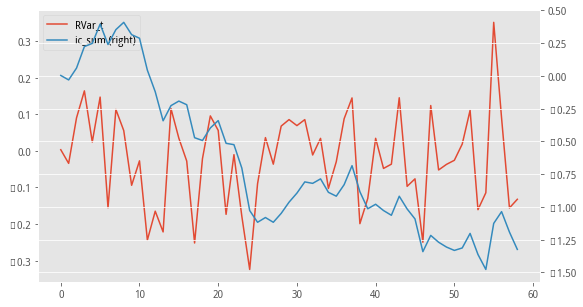

===================因子：RSkew_t IC统计信息如下===================
          IC均值     IC标准差     IC最小值     IC最大值   负IC占比
2014 -0.023669  0.055670 -0.084417  0.070824  0.8333
2015 -0.039935  0.143837 -0.239677  0.314533  0.7500
2016 -0.084644  0.071645 -0.175434  0.052700  0.8333
2017 -0.045741  0.078511 -0.173955  0.081130  0.5833
2018 -0.025379  0.103668 -0.155766  0.210500  0.6667
2019  0.033639  0.082029 -0.080334  0.125255  0.4000
所有年份 -0.039359  0.098964 -0.239677  0.314533  0.6949


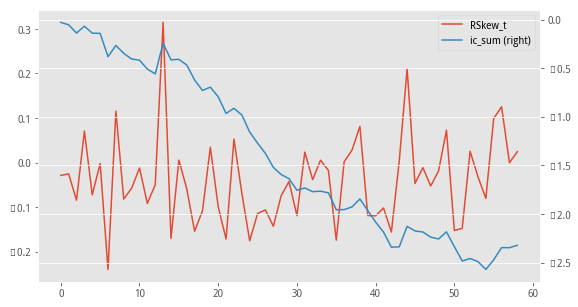

===================因子：RKurt_t IC统计信息如下===================
          IC均值     IC标准差     IC最小值     IC最大值   负IC占比
2014 -0.123877  0.095863 -0.241867  0.043353  0.8333
2015  0.020480  0.185306 -0.148885  0.536065  0.5833
2016 -0.063424  0.061922 -0.165946  0.018278  0.8333
2017 -0.024553  0.091542 -0.142975  0.154717  0.7500
2018 -0.011356  0.090781 -0.135398  0.150380  0.6667
2019  0.019796  0.064302 -0.047426  0.093411  0.6000
所有年份 -0.026958  0.115852 -0.241867  0.536065  0.7119


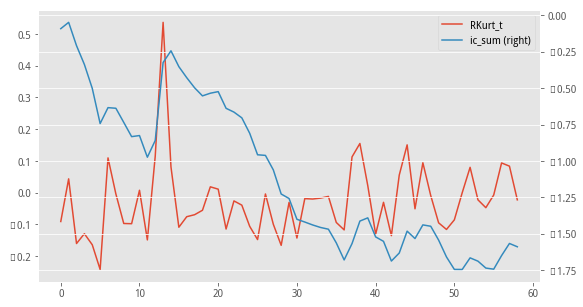

===================因子：RVar_t_short IC统计信息如下===================
          IC均值     IC标准差     IC最小值     IC最大值   负IC占比
2014  0.072096  0.077311 -0.016322  0.164664  0.3333
2015 -0.066085  0.134901 -0.249294  0.137523  0.6667
2016 -0.028381  0.127640 -0.306251  0.096486  0.5833
2017  0.001835  0.103627 -0.212676  0.147266  0.4167
2018 -0.023034  0.121363 -0.242224  0.163237  0.6667
2019  0.010885  0.207992 -0.145349  0.346749  0.6000
所有年份 -0.015271  0.127912 -0.306251  0.346749  0.5593


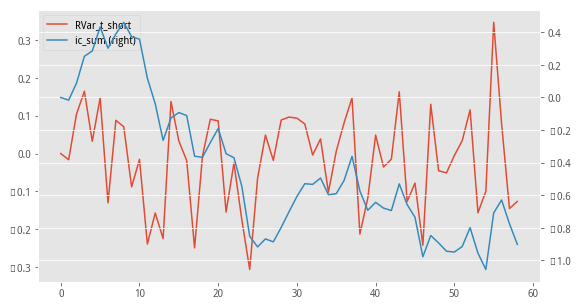

===================因子：1 IC统计信息如下===================
          IC均值     IC标准差     IC最小值     IC最大值   负IC占比
2014  0.027268  0.097342 -0.069201  0.193385  0.3333
2015 -0.003760  0.190773 -0.238995  0.354913  0.5833
2016 -0.056878  0.097632 -0.274125  0.082071  0.7500
2017 -0.007864  0.125753 -0.254862  0.162314  0.5000
2018 -0.034754  0.117436 -0.199318  0.154944  0.6667
2019  0.054993  0.213790 -0.169305  0.386788  0.6000
所有年份 -0.013568  0.139209 -0.274125  0.386788  0.5932


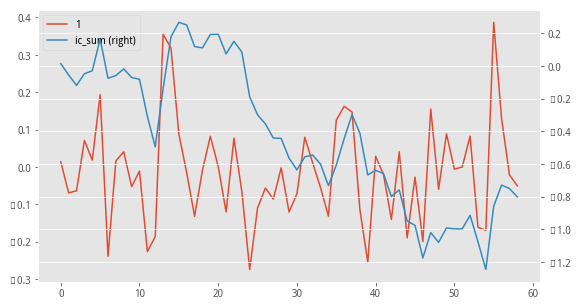

===================因子：2 IC统计信息如下===================
          IC均值     IC标准差     IC最小值     IC最大值   负IC占比
2014  0.005697  0.108712 -0.082583  0.203447  0.5000
2015  0.060784  0.091652 -0.098134  0.211631  0.2500
2016  0.032541  0.067639 -0.085115  0.117491  0.3333
2017  0.068534  0.058361 -0.018210  0.143280  0.2500
2018 -0.005365  0.091309 -0.115193  0.245049  0.5833
2019  0.088829  0.092735 -0.049962  0.196873  0.2000
所有年份  0.039936  0.085570 -0.115193  0.245049  0.3559


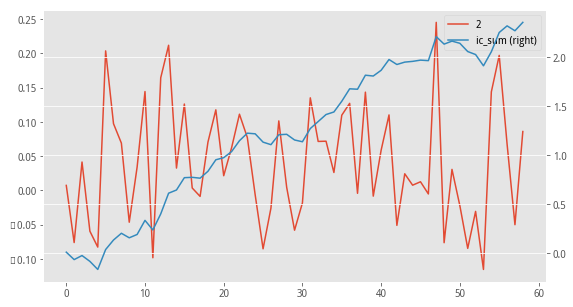

===================因子：3 IC统计信息如下===================
          IC均值     IC标准差     IC最小值     IC最大值   负IC占比
2014  0.000331  0.048383 -0.079961  0.054664  0.3333
2015 -0.030838  0.199697 -0.612859  0.154271  0.5000
2016  0.044909  0.070894 -0.050158  0.160050  0.3333
2017  0.059738  0.065917 -0.049048  0.157382  0.2500
2018  0.020374  0.053706 -0.055409  0.119228  0.4167
2019  0.010314  0.054046 -0.044442  0.101055  0.6000
所有年份  0.020064  0.106436 -0.612859  0.160050  0.3898


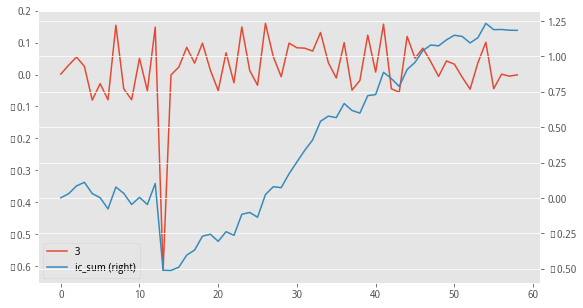

===================因子：4 IC统计信息如下===================
          IC均值     IC标准差     IC最小值     IC最大值   负IC占比
2014  0.029530  0.066350 -0.054105  0.140839  0.3333
2015  0.069872  0.139256 -0.067657  0.461855  0.3333
2016  0.023672  0.066264 -0.158717  0.086063  0.2500
2017  0.007737  0.065630 -0.061709  0.192101  0.5833
2018  0.030154  0.078663 -0.097043  0.154271  0.5000
2019 -0.011725  0.132390 -0.190729  0.168577  0.6000
所有年份  0.028742  0.093154 -0.190729  0.461855  0.4237


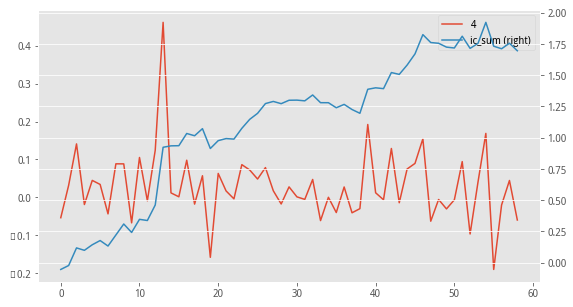

===================因子：5 IC统计信息如下===================
          IC均值     IC标准差     IC最小值     IC最大值   负IC占比
2014  0.014165  0.122079 -0.186072  0.138053  0.3333
2015  0.061308  0.148998 -0.034326  0.509756  0.5000
2016  0.033634  0.072040 -0.151787  0.094879  0.1667
2017  0.030143  0.092000 -0.071526  0.225773  0.5833
2018  0.055704  0.093614 -0.167000  0.192314  0.3333
2019 -0.031163  0.146788 -0.206913  0.145067  0.6000
所有年份  0.035570  0.109050 -0.206913  0.509756  0.4068


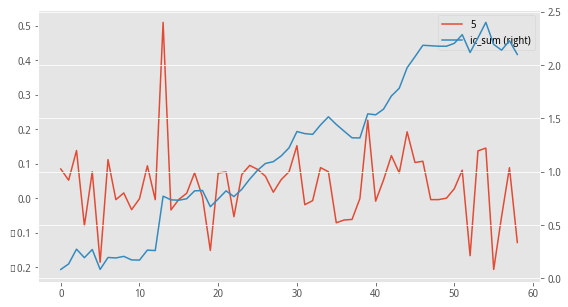

===================因子：6 IC统计信息如下===================
          IC均值     IC标准差     IC最小值     IC最大值   负IC占比
2014  0.032788  0.097637 -0.144431  0.145723  0.1667
2015 -0.008352  0.158958 -0.454975  0.168273  0.3333
2016  0.018893  0.065239 -0.106746  0.083943  0.4167
2017  0.007917  0.105882 -0.189198  0.185816  0.4167
2018  0.042556  0.080399 -0.076687  0.142288  0.3333
2019 -0.058077  0.170092 -0.319988  0.095934  0.4000
所有年份  0.010822  0.111926 -0.454975  0.185816  0.3559


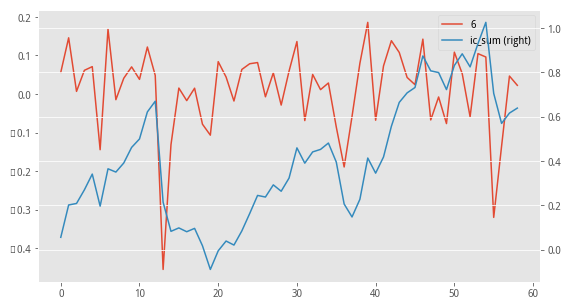

===================因子：7 IC统计信息如下===================
          IC均值     IC标准差     IC最小值     IC最大值   负IC占比
2014 -0.053292  0.056401 -0.106848  0.054401  0.8333
2015 -0.025731  0.214242 -0.599958  0.191191  0.4167
2016  0.042260  0.061598 -0.034001  0.181331  0.2500
2017  0.000216  0.093452 -0.166172  0.159854  0.5833
2018  0.013684  0.085194 -0.123966  0.140653  0.4167
2019 -0.068225  0.175153 -0.358204  0.050620  0.4000
所有年份 -0.005012  0.126737 -0.599958  0.191191  0.4576


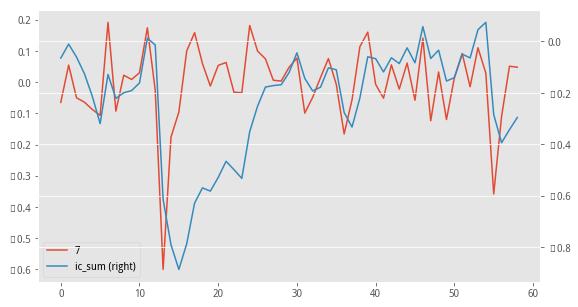

===================因子：8 IC统计信息如下===================
          IC均值     IC标准差     IC最小值     IC最大值   负IC占比
2014 -0.055300  0.069848 -0.163745  0.029413  0.8333
2015 -0.079453  0.168249 -0.421382  0.182732  0.6667
2016 -0.039006  0.083510 -0.138280  0.119946  0.5833
2017 -0.084131  0.057699 -0.152807  0.042954  0.9167
2018 -0.026858  0.088485 -0.195851  0.099584  0.6667
2019 -0.050112  0.083104 -0.123797  0.093288  0.8000
所有年份 -0.056538  0.101095 -0.421382  0.182732  0.7288


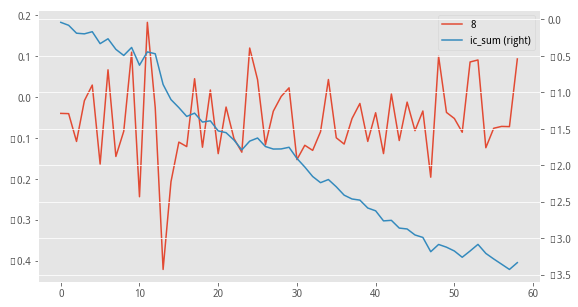

===================因子：corr IC统计信息如下===================
          IC均值     IC标准差     IC最小值     IC最大值   负IC占比
2014  0.036119  0.094570 -0.071392  0.152693  0.3333
2015 -0.097927  0.121644 -0.306622  0.070050  0.6667
2016 -0.069095  0.066170 -0.154645  0.053915  0.8333
2017 -0.014059  0.084266 -0.162810  0.157598  0.5833
2018 -0.067889  0.113305 -0.210345  0.148793  0.6667
2019 -0.009577  0.047928 -0.076516  0.041911  0.4000
所有年份 -0.047776  0.100672 -0.306622  0.157598  0.6271


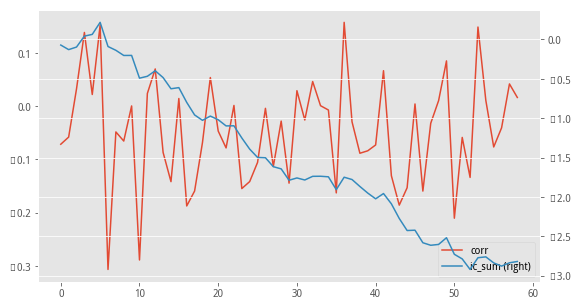

===================因子：flowinratio IC统计信息如下===================
          IC均值     IC标准差     IC最小值     IC最大值   负IC占比
2014 -0.177784  0.077032 -0.282977 -0.077042  1.0000
2015 -0.056486  0.177544 -0.281613  0.291437  0.5000
2016 -0.102829  0.165643 -0.331363  0.177849  0.6667
2017  0.039051  0.068904 -0.067386  0.147900  0.3333
2018 -0.039439  0.155911 -0.274609  0.201607  0.5833
2019 -0.016057  0.140198 -0.193534  0.124367  0.4000
所有年份 -0.051922  0.150314 -0.331363  0.291437  0.5593


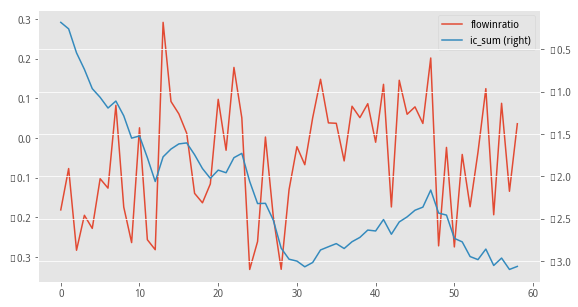

===================因子：er IC统计信息如下===================
          IC均值     IC标准差     IC最小值     IC最大值   负IC占比
2014  0.013795  0.127318 -0.162496  0.191329  0.5000
2015 -0.058437  0.295772 -0.407837  0.723091  0.6667
2016 -0.014888  0.115827 -0.192909  0.136159  0.5000
2017  0.056412  0.130390 -0.253082  0.312619  0.1667
2018 -0.024173  0.097225 -0.203819  0.115040  0.6667
2019 -0.034480  0.096221 -0.161181  0.054491  0.4000
所有年份 -0.009876  0.166564 -0.407837  0.723091  0.4915


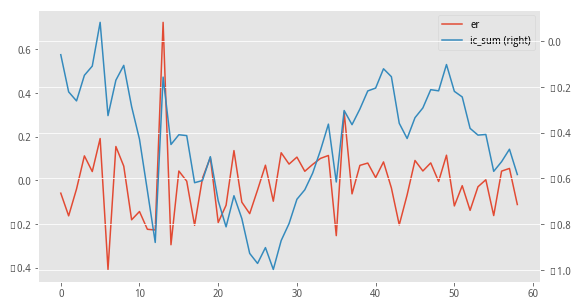

===================因子：r IC统计信息如下===================
          IC均值     IC标准差     IC最小值     IC最大值   负IC占比
2014 -0.017903  0.128065 -0.185459  0.125645  0.5000
2015 -0.164949  0.206583 -0.662190  0.138212  0.7500
2016 -0.044133  0.067623 -0.125160  0.061568  0.6667
2017 -0.017279  0.121806 -0.322132  0.209978  0.5000
2018 -0.044079  0.076015 -0.211717  0.050459  0.6667
2019 -0.094058  0.099130 -0.245168  0.022301  0.8000
所有年份 -0.064796  0.134102 -0.662190  0.209978  0.6441


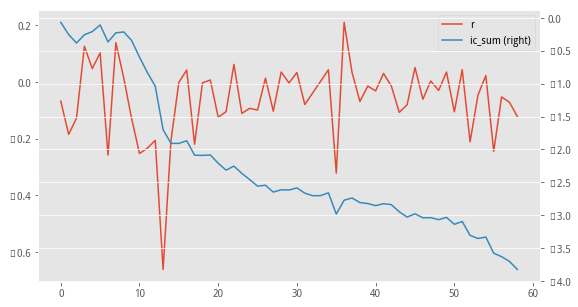

In [8]:
#所有因子信息统计如下
for factor in ic_df.index:
    ic_ = ic_df.T
    ic_df_temp = ic_df.T[factor]
    tab_ic = pd.DataFrame()
    
    for year in range(2014,2020):
        #表格统计
        ic_temp = ic_[(ic_.index>(str(year)+'-01-01')) & (ic_.index<(str(year+1)+'-01-01'))]
        tab_ic[str(year)] = [ic_temp[factor].mean(),ic_temp[factor].std(),ic_temp[factor].min(),ic_temp[factor].max(),round(sum(ic_temp[factor]<0)/len(ic_temp),4)]

    tab_ic['所有年份'] = [ic_[factor].mean(),ic_[factor].std(),ic_[factor].min(),ic_[factor].max(),round(sum(ic_[factor]<0)/len(ic_),4)]
    tab_ic.index=['IC均值','IC标准差',"IC最小值","IC最大值","负IC占比"]
    print('========================因子：{} IC统计信息如下======================'.format(factor))
    print(tab_ic.T)
    
    #进行IC值展示
    ic_df_temp1 = ic_df.T[[factor]]
    ic_df_temp1['ic_sum'] = ic_df_temp1[factor].cumsum()
    ic_df_temp1.plot(use_index=False,y=[factor,'ic_sum'],secondary_y=['ic_sum'],figsize=(9,5))
    plt.show()

### 分组回测
- 多头收益
- 分组收益

接下来，我们将对所有因子值进行分组收益统计，并记录各分组总收益、年化收益、夏普率、最大回撤、每日收益情况

并将分组年化收益进行统计展示

=========================因子： RVar_t 分组收益如下==========================
            总收益    年化收益    夏普率    最大回撤   每日收益%
group0    10.1%   1.93%  -0.02  71.12%    0.03
group1   93.34%  13.99%   0.35  57.01%  0.0746
group2   89.08%  13.48%   0.35  55.33%   0.071
group3   107.2%  15.56%   0.42   47.5%  0.0772
group4  131.59%  18.15%   0.52  46.27%  0.0848
group5  128.45%  17.83%   0.51  47.64%  0.0843
group6  124.78%  17.45%    0.5  48.48%  0.0825
group7   85.41%  13.04%   0.35  45.74%  0.0669
group8   77.36%  12.05%   0.33   52.2%  0.0629
group9   75.16%  11.77%   0.33  50.38%  0.0601


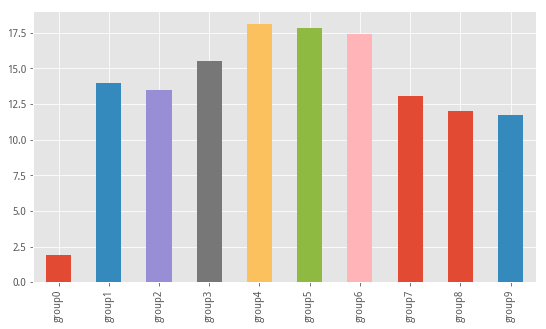

=========================因子： RSkew_t 分组收益如下==========================
            总收益    年化收益   夏普率    最大回撤   每日收益%
group0   25.47%   4.61%  0.07  65.74%   0.038
group1    44.4%   7.57%  0.16  63.27%  0.0486
group2   95.59%  14.25%  0.38  50.74%  0.0725
group3   94.12%  14.08%  0.38  50.76%   0.072
group4   38.13%   6.63%  0.13  56.17%  0.0449
group5   97.34%  14.45%   0.4  49.04%  0.0725
group6   90.54%  13.66%  0.38  50.14%  0.0691
group7  121.72%  17.13%  0.49  45.65%   0.081
group8  200.43%  24.41%  0.73  46.56%  0.1054
group9  130.32%  18.02%  0.52  46.14%  0.0842


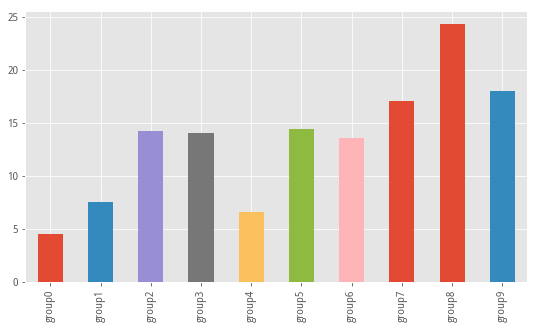

=========================因子： RKurt_t 分组收益如下==========================
            总收益    年化收益   夏普率    最大回撤   每日收益%
group0   33.26%   5.87%  0.11  56.66%  0.0406
group1   81.65%  12.58%  0.34   55.2%   0.065
group2    52.8%   8.78%  0.21  56.61%  0.0523
group3   79.73%  12.35%  0.32   50.8%  0.0652
group4   91.47%  13.77%  0.37  51.46%  0.0706
group5  104.24%  15.23%  0.42  47.46%  0.0757
group6    91.8%  13.81%  0.36  48.51%  0.0714
group7    89.1%  13.49%  0.35  55.97%  0.0704
group8  114.59%  16.37%  0.45  48.09%  0.0799
group9  160.09%   20.9%  0.61  48.47%  0.0941


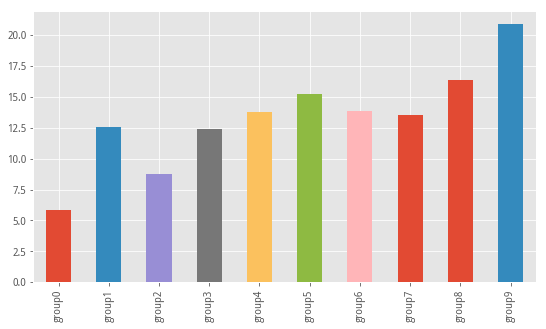

=========================因子： RVar_t_short 分组收益如下==========================
            总收益    年化收益   夏普率    最大回撤   每日收益%
group0   17.98%   3.34%  0.03  70.16%  0.0358
group1    95.8%  14.27%  0.36  54.09%  0.0752
group2   90.94%   13.7%  0.35  56.16%  0.0716
group3  123.13%  17.28%  0.48  48.33%   0.083
group4  105.44%  15.37%  0.42  48.28%   0.076
group5  121.11%  17.07%  0.49  47.08%  0.0812
group6   142.6%  19.24%  0.55  48.88%  0.0891
group7   79.08%  12.27%  0.33  47.58%  0.0639
group8   63.15%  10.21%  0.26  52.99%  0.0563
group9   74.17%  11.65%  0.33  51.61%  0.0598


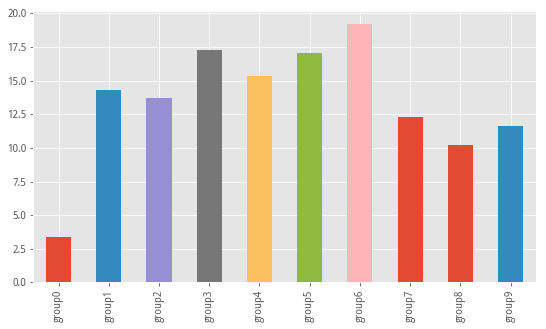

=========================因子： 1 分组收益如下==========================
            总收益    年化收益    夏普率    最大回撤   每日收益%
group0   10.01%   1.91%  -0.02  69.66%    0.03
group1   64.68%  10.41%   0.24  58.92%  0.0617
group2  123.66%  17.33%   0.47  52.29%  0.0844
group3   87.03%  13.24%   0.35  52.48%  0.0693
group4  124.26%  17.39%   0.49  51.75%  0.0832
group5   91.39%  13.76%   0.38  49.85%  0.0695
group6   98.46%  14.58%    0.4  47.16%  0.0728
group7  125.31%   17.5%   0.51   49.5%  0.0824
group8   75.06%  11.76%   0.33  50.85%  0.0609
group9  120.53%   17.0%   0.52  40.06%  0.0787


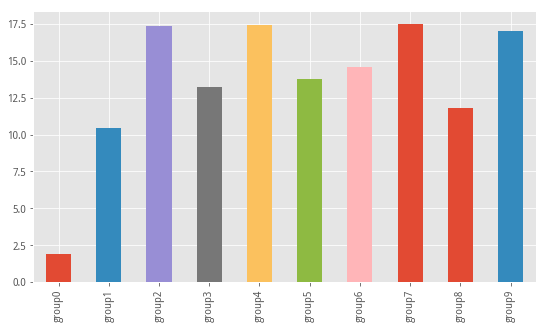

=========================因子： 2 分组收益如下==========================
            总收益    年化收益   夏普率    最大回撤   每日收益%
group0  175.91%  22.33%  0.62  46.18%   0.101
group1  124.17%  17.39%  0.48  50.13%  0.0839
group2  131.95%  18.18%  0.51  50.17%  0.0859
group3   98.44%  14.58%   0.4  51.54%  0.0733
group4  107.99%  15.65%  0.43  48.54%  0.0769
group5   65.46%  10.52%  0.26   55.8%  0.0593
group6   40.71%   7.02%  0.15  58.69%  0.0452
group7   96.69%  14.38%   0.4  53.06%  0.0718
group8   96.68%  14.37%  0.39  49.05%  0.0722
group9   28.06%   5.03%  0.09  59.73%  0.0368


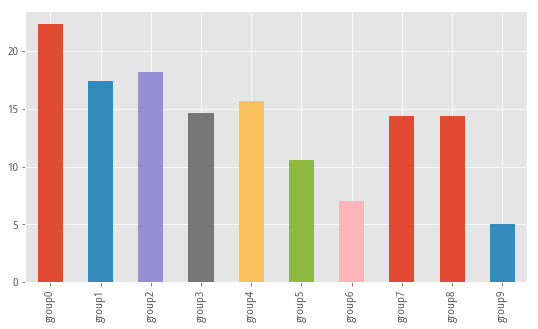

=========================因子： 3 分组收益如下==========================
            总收益    年化收益   夏普率    最大回撤   每日收益%
group0  161.22%  21.01%  0.62  46.26%  0.0942
group1  102.89%  15.08%  0.42   47.0%   0.074
group2   99.11%  14.65%   0.4   47.8%  0.0731
group3  117.61%  16.69%  0.47  46.43%  0.0804
group4  105.33%  15.36%  0.42  54.24%  0.0766
group5   95.32%  14.22%  0.38  50.65%  0.0725
group6   89.13%  13.49%  0.36  51.02%    0.07
group7  110.65%  15.94%  0.44  49.47%  0.0777
group8   33.21%   5.86%  0.11  61.31%   0.042
group9    28.4%   5.09%  0.09  68.23%  0.0382


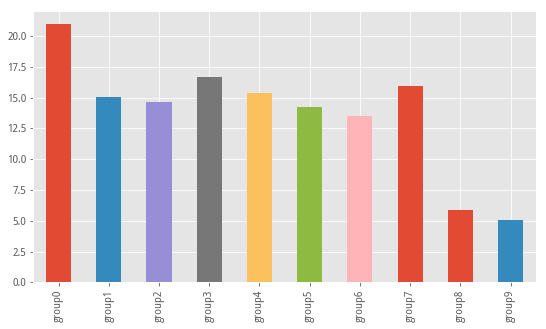

=========================因子： 4 分组收益如下==========================
            总收益    年化收益   夏普率    最大回撤   每日收益%
group0   87.76%  13.33%  0.37  50.57%  0.0673
group1  138.91%  18.88%  0.56  46.38%  0.0866
group2  134.79%  18.47%  0.53  45.94%  0.0862
group3  112.91%  16.19%  0.45  48.41%  0.0789
group4   75.09%  11.76%  0.31  47.68%  0.0631
group5   70.23%  11.14%  0.28  51.57%  0.0614
group6  112.49%  16.15%  0.45  48.68%  0.0787
group7   113.8%  16.29%  0.45  54.47%  0.0798
group8   53.66%    8.9%  0.21   60.2%  0.0534
group9    45.6%   7.75%  0.17  64.52%  0.0491


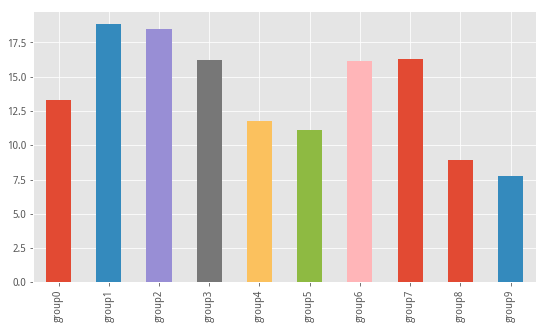

=========================因子： 5 分组收益如下==========================
            总收益    年化收益   夏普率    最大回撤   每日收益%
group0  115.54%  16.47%  0.49  45.14%  0.0775
group1   84.61%  12.95%  0.36   50.7%  0.0662
group2  137.77%  18.77%  0.55   41.9%  0.0867
group3  136.65%  18.66%  0.54   46.6%  0.0863
group4  114.89%   16.4%  0.46  49.42%  0.0793
group5   87.17%  13.26%  0.35  50.49%  0.0687
group6   77.93%  12.12%  0.31  58.41%  0.0649
group7   82.12%  12.64%  0.33  53.59%  0.0673
group8   76.19%   11.9%   0.3  56.03%  0.0646
group9   45.67%   7.76%  0.16  63.82%   0.051


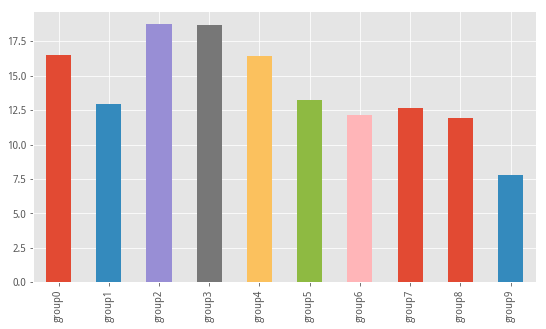

=========================因子： 6 分组收益如下==========================
            总收益    年化收益   夏普率    最大回撤   每日收益%
group0  112.45%  16.14%  0.48  48.52%  0.0765
group1  131.02%  18.09%  0.53  45.93%  0.0838
group2   84.48%  12.93%  0.35  51.44%  0.0669
group3   99.55%   14.7%  0.41  46.89%  0.0729
group4   103.2%  15.12%  0.42  50.11%  0.0749
group5  105.42%  15.37%  0.42  47.79%  0.0762
group6   96.76%  14.38%  0.39   47.3%  0.0728
group7   58.07%   9.52%  0.23  59.97%  0.0552
group8  122.09%  17.17%  0.46  51.66%  0.0839
group9   33.38%   5.89%  0.11  64.31%  0.0431


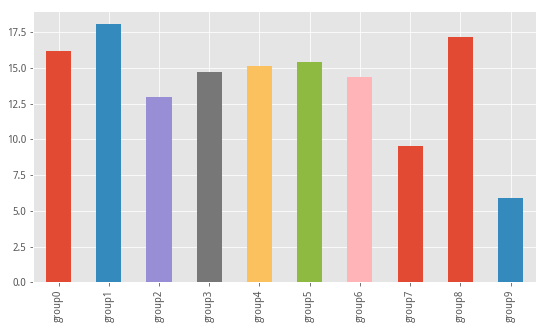

=========================因子： 7 分组收益如下==========================
            总收益    年化收益   夏普率    最大回撤   每日收益%
group0   94.12%  14.08%   0.4  49.06%  0.0698
group1  107.57%  15.61%  0.44  49.16%  0.0756
group2   73.82%   11.6%  0.31  51.42%  0.0617
group3  100.15%  14.77%  0.41  47.58%  0.0733
group4   94.58%  14.13%  0.39  50.64%  0.0705
group5   104.5%  15.26%  0.42  47.69%  0.0752
group6   77.06%  12.01%  0.31  50.79%  0.0643
group7   67.03%  10.72%  0.27   54.4%    0.06
group8   68.65%  10.94%  0.26  61.05%  0.0621
group9   95.17%   14.2%  0.36  55.99%  0.0742


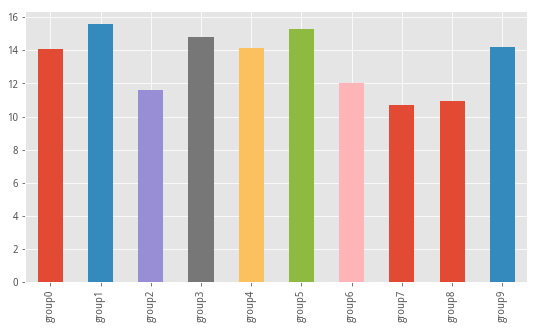

=========================因子： 8 分组收益如下==========================
            总收益    年化收益   夏普率    最大回撤   每日收益%
group0   24.94%   4.52%  0.07  64.76%  0.0351
group1   24.21%    4.4%  0.06  60.72%  0.0359
group2   74.49%  11.69%  0.31  55.19%  0.0625
group3   68.65%  10.94%  0.28  56.93%  0.0601
group4   56.83%   9.35%  0.22  58.63%  0.0551
group5  129.48%  17.93%  0.51  44.78%  0.0847
group6   87.64%  13.31%  0.36  54.28%  0.0686
group7  144.86%  19.46%  0.55  48.91%  0.0905
group8  136.17%  18.61%  0.53  47.63%  0.0869
group9  210.23%  25.21%  0.72  48.07%  0.1098


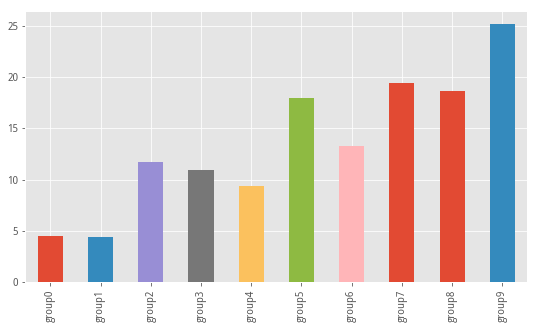

=========================因子： corr 分组收益如下==========================
            总收益    年化收益   夏普率    最大回撤   每日收益%
group0  -16.85%   -3.6%  -0.2  74.06%  0.0046
group1   52.81%   8.78%   0.2  55.02%  0.0528
group2    63.5%  10.25%  0.26  51.18%  0.0575
group3   66.18%  10.61%  0.27  55.84%  0.0593
group4   81.05%  12.51%  0.33  56.96%  0.0656
group5   157.1%  20.62%  0.59  45.86%  0.0938
group6   193.7%  23.85%   0.7  48.14%  0.1042
group7  110.21%   15.9%  0.44  48.28%  0.0777
group8   121.9%  17.15%  0.49  47.37%  0.0817
group9  141.36%  19.12%  0.54  50.03%  0.0889


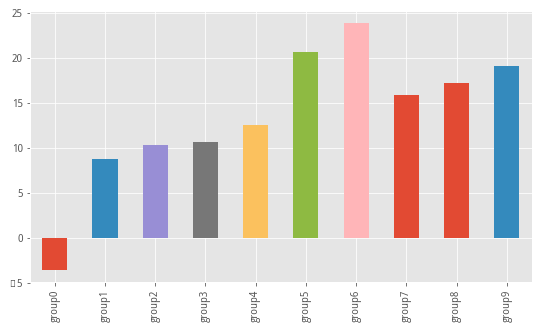

=========================因子： flowinratio 分组收益如下==========================
            总收益    年化收益    夏普率    最大回撤   每日收益%
group0  -16.68%  -3.56%  -0.18  70.02%  0.0081
group1   41.17%   7.09%   0.14  52.43%  0.0485
group2   53.48%   8.88%    0.2  52.17%  0.0546
group3   83.66%  12.83%   0.34  53.09%  0.0671
group4   107.7%  15.62%   0.43  48.71%   0.077
group5   65.94%  10.58%   0.27  57.57%  0.0585
group6  152.64%  20.21%    0.6  44.34%  0.0914
group7  103.01%   15.1%   0.43  50.82%  0.0737
group8  154.68%   20.4%   0.61  47.06%   0.092
group9  227.59%  26.57%   0.83  45.02%  0.1115


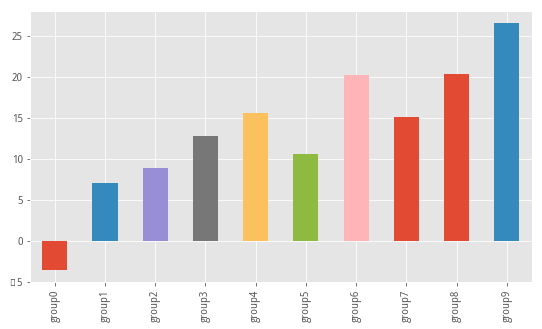

=========================因子： er 分组收益如下==========================
            总收益    年化收益   夏普率    最大回撤   每日收益%
group0   31.91%   5.65%   0.1  61.24%  0.0432
group1   36.18%   6.32%  0.12  56.08%  0.0435
group2  116.42%  16.57%  0.46  51.39%  0.0802
group3   91.65%  13.79%  0.38  48.25%  0.0699
group4   87.88%  13.34%  0.36  50.04%  0.0689
group5   86.68%   13.2%  0.35  51.29%  0.0684
group6   86.61%  13.19%  0.35  56.84%  0.0682
group7   131.7%  18.16%  0.52  49.57%   0.085
group8  111.55%  16.04%  0.45  54.38%  0.0777
group9  137.81%  18.77%  0.54   43.4%  0.0873


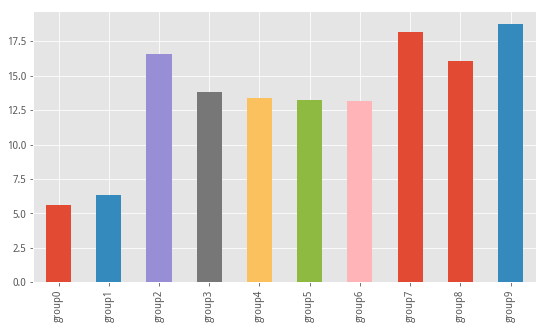

=========================因子： r 分组收益如下==========================
            总收益    年化收益    夏普率    最大回撤   每日收益%
group0  -16.34%  -3.48%  -0.19  71.82%  0.0058
group1   49.66%   8.34%   0.19   54.1%  0.0514
group2   94.74%  14.15%   0.38  48.09%  0.0715
group3   82.01%  12.63%   0.34  51.04%  0.0653
group4   98.85%  14.62%    0.4  48.49%  0.0728
group5   74.08%  11.64%   0.31   53.2%  0.0619
group6  115.16%  16.43%   0.46  46.93%  0.0791
group7  109.34%   15.8%   0.44  54.89%  0.0773
group8  162.32%  21.11%    0.6  48.45%   0.096
group9  196.92%  24.12%    0.7   41.5%  0.1058


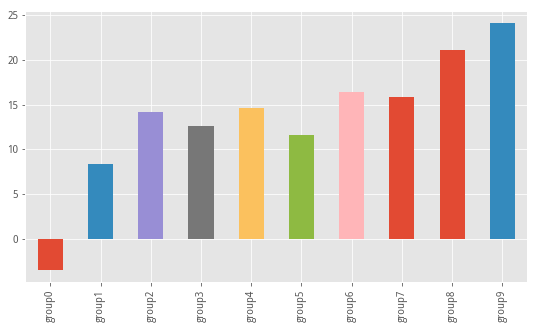

In [13]:
#进行因子值回测分组收益统计
#分组个数
group = 10 #分组组数

factor_list = list(ic_df.index)#获取所有统计因子值

def get_risk_index(se): #输入每日收益变化，从零算起
    return_se = se.cumprod()-1
    total_returns = return_se[-1]
    total_an_returns = ((1+total_returns)**(250/len(return_se))-1)
    sharpe = (total_an_returns-0.025)/(np.std(se)*np.sqrt(250))
    returns_mean = round(se.mean()-1,6)*100
    ret = return_se.dropna()
    ret = ret+1
    maxdown_list = []
    for i in range(1,len(ret)):
        low  = min(ret[i:])
        high = max(ret[0:i]) 
        if high>low:
            #print(high,low)
            maxdown_list.append((high-low)/high)
            #print((high-low)/high)
        else:
            maxdown_list.append(0)
    max_drawdown = max(maxdown_list)
    #print('策略运行时间：{} 至 {}'.format(str(return_se.index[0])[:10],str(return_se.index[-1])[:10]))
    total_returns = str(round(total_returns*100,2))+'%'
    total_an_returns = str(round(total_an_returns*100,2))+'%'
    sharpe = str(round(sharpe,2))
    max_drawdown = str(round(max_drawdown*100,2))+'%'
    
    '''
    print('总收益：%s'%round(total_returns*100,2)+'%')
    print('年化收益：%s'%round(total_an_returns*100,2)+'%')
    print('夏普比率：%s'%round(sharpe,2))
    print('最大回撤：%s'%round(max_drawdown*100,2)+'%')
    '''
    
    return total_returns,total_an_returns,sharpe,max_drawdown,returns_mean

for factor in factor_list:
    factor_df = pd.DataFrame()
    for d in trade_list[:]:
        d = str(d)[:10]
        factor_df[d] = factor1_dict[d].loc[:,factor]#/factor_dict[d].loc[:,'turnover_ratio']
    factor_df =factor_df.T
    #统计分组收益
    #分组回测分析
    #输入：index为日期，column是股票名，values是因子值得factor_df
    #输出：股票池分组收益
    pool_dict = {}
    for i in range(len(factor_df.index)):
        temp_se = factor_df.iloc[i,:].sort_values(ascending=False)#从大到小排序
        #pool = temp_se[temp_se>0].index #去掉小于0的值
        temp_se = temp_se.dropna() #去掉空值
        pool = temp_se.index #不做负值处理
        num = int(len(pool)/group)
        #print('第%s期每组%s只股票'%(i,num))
        pool_dict[factor_df.index[i]] = pool
    backtest_list = factor_df.index
    group_pct = get_all_pct(pool_dict,backtest_list,groups=group)
    group_pct.columns = ['group'+str(i) for i in range(len(group_pct.columns))]
    
    #进行分组收益统计
    risk_index = group_pct.apply(get_risk_index,axis=0)
    risk_tab = pd.DataFrame(index=["总收益","年化收益","夏普率","最大回撤","每日收益%"])
    for i in range(group):
        risk_tab['group'+str(i)] = list(risk_index.values[i])
    print('=========================因子： {} 分组收益如下=========================='.format(factor))
    print(risk_tab.T)
    risk_plt = pd.Series([float(str(i)[:-1]) for i in risk_tab.values[1]],index=risk_tab.T.index)
    risk_plt.plot(kind='bar',figsize=(9,5))
    plt.show()

这里我们将表现较好的因子取出，对其分组收益情况进行展示，可以看到头尾收益差额较大，分组效果明显。

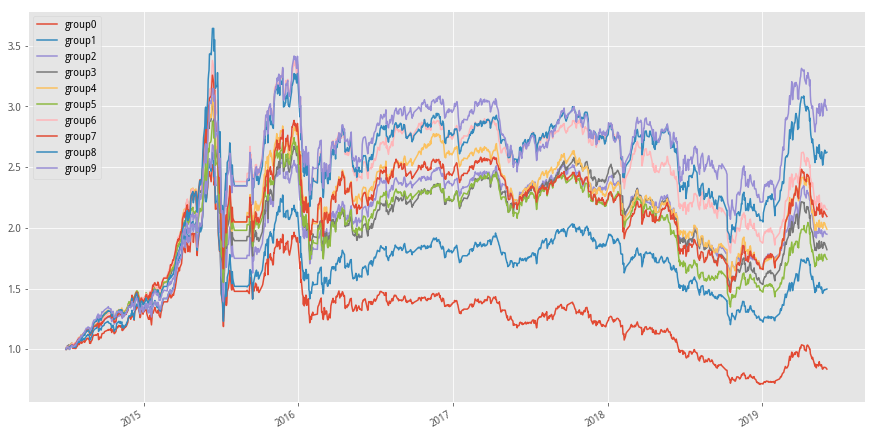

In [15]:
#分组回测曲线
#设置检查因子
factor = 'r'
factor_df = pd.DataFrame()

for d in trade_list[:]:
    d = str(d)[:10]
    factor_df[d] = factor1_dict[d].loc[:,factor]#/factor_dict[d].loc[:,'turnover_ratio']
factor_df =factor_df.T

pool_dict = {}
for i in range(len(factor_df.index)):
    temp_se = factor_df.iloc[i,:].sort_values(ascending=False)#从大到小排序
    #pool = temp_se[temp_se>0].index #去掉小于0的值
    temp_se = temp_se.dropna() #去掉空值
    pool = temp_se.index #不做负值处理
    num = int(len(pool)/group)
    #print('第%s期每组%s只股票'%(i,num))
    pool_dict[factor_df.index[i]] = pool
backtest_list = factor_df.index
group_pct = get_all_pct(pool_dict,backtest_list,groups=group)
group_pct.columns = ['group'+str(i) for i in range(len(group_pct.columns))]
group_pct.cumprod().plot(figsize=(15,8))

### 因子相关性检查

股票高频因子秩相关系数矩阵如下表所示，大多数因子间具有较低的相关性，而下行波动率占比和高频偏度因子间具有较高的负相关性，

- 成交量占比中我们发现，9:30-10:00成交量占比与下午11:00以后的所有分段成交量占比负相关关系较强
- 高频峰度因子与 高频偏度因子、资金流入因子成较强的正相关关系
- 趋势强度因子与改进反转因子，因为在描述同一件事情，虽然处理方式上有所不同，但是二者仍然有着较强正相关关系

In [ ]:
import seaborn as sns
df = factor_y_dict[list(factor_y_dict.keys())[-1]].corr(method='spearman')
fig = plt.figure(figsize= (12,8))
ax = fig.add_subplot(111)
ax = sns.heatmap(df,annot=True,annot_kws={'size':9,'weight':'bold'})

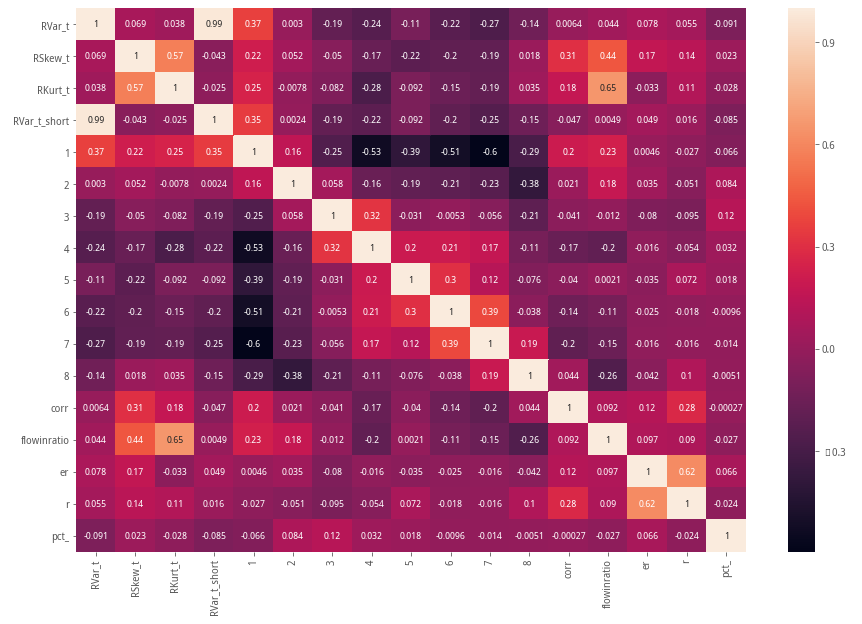

### 结论

本篇报告中我们使用分钟级别数据构建了一系列高频因子，并对比各因子在股票中的表现，具体的因子表现看参见研究前面的结论内容

1）高频偏度、量价相关性因子、以及改进反转一致具有显著的选股效果。成交量分布因子在上午和下午呈现出不同的选股效果，收盘前成交量越大的股票未来表现越差，而上午 10-11 点成交量越大的股票未来表现越好。 

2）通过日内信息对传统因子进行改进，反转因子在进行改造后分层效果明显，多空组合年化收益差可达27.6%，最优分组年化收益到达24.12%。

3）多数高频因子在股票中体现出反转效应，可能与交易机制和投资者结构有关。股票市场以单向做多机制为主，相比于可以多空双向 T+0 交易，机构参与度高，程序化交易应用广泛的期货市场，股票市场散户交易占比较高，更容易出现过度反应和定价偏误。
